# Triplet CNN Software

In [ ]:
%autosave 0

In [19]:
# Python Imaging Library
from PIL import Image    
import PIL.ImageOps

# Packages
import torch
from torch.utils.data import DataLoader,Dataset
from torch import optim     # 包含optimization algorithms
import torch.nn.functional as F     # 包含activation functions
from torch.autograd import Variable      # 以Variable形式嵌套激励函数 
import torch.nn as nn

# Torchvision 包含目前流行的数据集，模型结构和常用的图片转换工具等
import torchvision
import torchvision.datasets as dset    # 包含一些数据集
import torchvision.transforms as transforms  # 可对PIL.Image, Tensor进行变换
import torchvision.utils  ##

# Others
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import linecache
import seaborn as sns

In [20]:
class Config():
    training_dir = "./Datasets/att/training/"
    validation_dir = "./Datasets/att/validamulti/"
    testing_dir = "./Datasets/att/testing/"
    batch_ap_path = 'batch_ap_mixed.txt'
    batch_an_path = 'batch_an_mixed.txt'
    batch_ap_hard_path = './batch_ap_hard_mixed.txt'
    batch_an_hard_path = './batch_an_hard_mixed.txt'
    train_batch_size = 32           #批样本数
    train_number_epoch = 400     #整批训练次数，即遍历了多少次所有的训练样本

In [21]:
def imshow(img, text=None, should_save=False):     #数据集出图
    npimg = img.numpy()   #转numpy
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                bbox={'facecolor':'white','alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

## Loaders

In [22]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('L')

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [23]:
class DataTriplet(Dataset):
    def __init__(self, path_a, path_b, data_transforms=None, loader = default_loader):
        self.path_a = path_a
        self.path_b = path_b  
        self.data_transforms = data_transforms
        self.loader = loader

    def __len__(self):
        return len(self.path_a)

    def __getitem__(self, item):
        img_a = self.loader(path_a)
        img_b = self.loader(path_b)
        img_c = self.loader('./ceshi/pic_helper.png')

        
        if self.data_transforms is not None:
            try:
                img_a = self.data_transforms(img_a)
            except:
                print("Cannot transform image: {}".format(img_a))
            try:
                img_b = self.data_transforms(img_b)
            except:
                print("Cannot transform image: {}".format(img_s))
            try:
                img_c = self.data_transforms(img_c)
            except:
                print("Cannot transform image: {}".format(img_c))
                
        return img_a, img_b, img_c

## Triplet CNN

In [24]:
class TripletNetwork(nn.Module):                 # torch.nn.Module:所有神经网络模块的基类
    def __init__(self):
        super(TripletNetwork, self).__init__()
        self.cnn1 = nn.Sequential(               # torch.nn.Sequential:模块将按照在构造器中的顺序传递
            nn.ReflectionPad2d(1),               # 使用输入边界的反射来填充输入张量
            nn.Conv2d(                           # 对信号（由若干输入平面组成）进行2维卷积
                in_channels=1,                   # input height. 灰度图1层，RGB为3层，即图像的通道数
                out_channels=4,                  # n_filters 过滤器数目，过滤器提取的特征数
                kernel_size=3,                   # 卷积核 filter size 3x3
                stride=1,                        # filter movement/step 跳度
                padding=0,                       # 零填充。若想要con2d出来的图片长宽没有变化，当stride=1,padding=(kernel_size-1)/2
            ),
            nn.ReLU(inplace=True),               # ReLU(x)=max(0,x), inplace不是很懂
            nn.BatchNorm2d(4),                   # 对4维输入应用批标准化（一个小批量的2维输入和额外的通道尺寸）？
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(
                in_channels=4,
                out_channels=8,
                kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )
        
        self.fc1 = nn.Sequential(                   # fc full connected
            nn.Linear(in_features=8*100*100,        # 线性层,y=Ax+b
                      out_features=500),
            nn.ReLU(inplace=True),
            
            nn.Linear(500,500),
            nn.ReLU(inplace=True),
            
            nn.Linear(500,50)
    )
    
    def forward_once(self,x):
        output = self.cnn1(x)
        output = output.view(output.size()[0],-1)   #Morvan说是展平多维的卷积图。check:http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1,output2,output3
    
net = TripletNetwork()
print(net)

TripletNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True)
    (4): Dropout2d(p=0.2)
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace)
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
    (9): Dropout2d(p=0.2)
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace)
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
    (14): Dropout2d(p=0.2)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=50, bias=True)
  )
)


In [25]:
net.load_state_dict(torch.load('tri_batch_mixed_params.pkl'))

In [26]:
class TripletNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)   #在self...imgs中返回随机项
        # 先取A-P对，保持循环，直到找到相同的类的图像
        while True:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)   #元组=（图片路径，类编号）
            if img0_tuple[1] == img1_tuple[1]:                         #图片编号相同则是同一个类（以文件夹区分）
                break
        # 再取A-N
        while True:
            img2_tuple = random.choice(self.imageFolderDataset.imgs)
            if img0_tuple[1] != img2_tuple[1]:
                break

        img0 = Image.open(img0_tuple[0])    #读取实际图像，tuple[0]即路径
        img1 = Image.open(img1_tuple[0])
        img2 = Image.open(img2_tuple[0])
        img0 = img0.convert("L")            #from PIL，把img转换为256级灰度图像， L：8-bit pixels,black and white
        img1 = img1.convert("L")
        img2 = img2.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)    #将输入图像转换为反色图像
            img1 = PIL.ImageOps.invert(img1)
            img2 = PIL.ImageOps.invert(img2)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return img0, img1, img2
            #返回 img0,img1,img2，完成A-P-N组合
    
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)          #数据集大小

## 软件结果

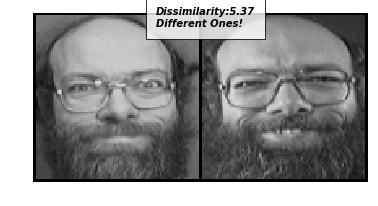

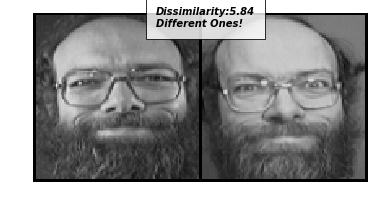

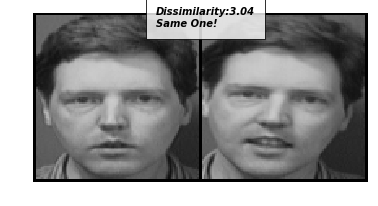

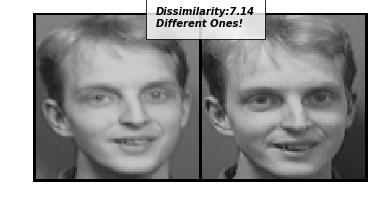

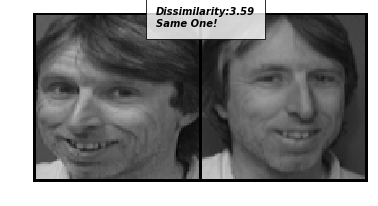

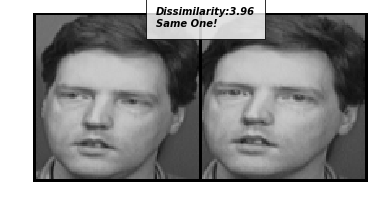

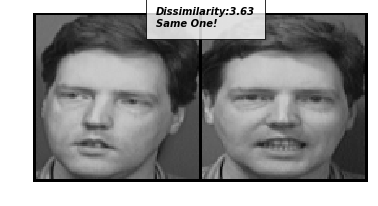

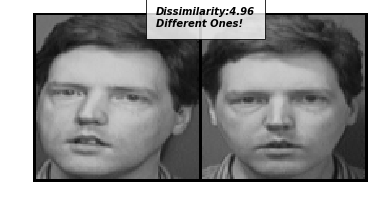

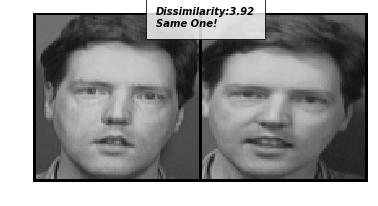

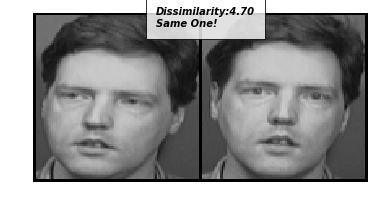

In [27]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
triplet_dataset = TripletNetworkDataset(imageFolderDataset=folder_dataset_test,
                                       transform=transforms.Compose([transforms.Resize((100,100)),
                                                                    transforms.ToTensor()
                                                                    ]),
                                       should_invert=False)

test_dataloader = DataLoader(triplet_dataset, num_workers=6, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

threshold = 4.95

for i in range(10):
    x0, x1, x2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1, output2, output3 = net(Variable(x0), Variable(x1),Variable(x2))     #Variable(x0).cuda()
    eu_distance = F.pairwise_distance(output1, output2)
    eu_dist = eu_distance.cpu().data.numpy()[0][0]
    if eu_dist <= threshold:
        imshow(torchvision.utils.make_grid(concatenated),
           'Dissimilarity:{:.2f}\nSame One!'.format(eu_dist))
    else:
        imshow(torchvision.utils.make_grid(concatenated),
           'Dissimilarity:{:.2f}\nDifferent Ones!'.format(eu_dist)) 

## 输入特定图片对进行比对

In [28]:
def TripletSoftware(path_a, path_b):
    try_datasets = DataTriplet(path_a = path_a, 
                             path_b = path_b,
                             data_transforms=transforms.Compose([transforms.Resize((100,100)),
                                                                         transforms.ToTensor()
                                                                         ]),
                                 )
    try_dataloaders = DataLoader(try_datasets,
                        batch_size=1,
                        shuffle=False)
    dataiter = iter(try_dataloaders)
    x0,_,_ = next(dataiter)

    threshold = 4.95


    x0, x1, x2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1, output2, output3 = net(Variable(x0), Variable(x1), Variable(x2))     #Variable(x0).cuda()
    eu_distance = F.pairwise_distance(output1, output2)
    eu_dist = eu_distance.cpu().data.numpy()[0][0]
    if eu_dist <= threshold:
        imshow(torchvision.utils.make_grid(concatenated),
           'Dissimilarity:{:.2f}\nSame One!'.format(eu_dist))
    else:
        imshow(torchvision.utils.make_grid(concatenated),
           'Dissimilarity:{:.2f}\nDifferent Ones!'.format(eu_dist))    

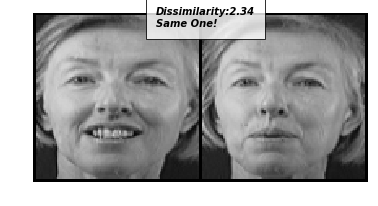

CPU times: user 519 ms, sys: 4.9 ms, total: 524 ms
Wall time: 150 ms


In [29]:
%%time
path_a = './Datasets/att/validation/s32/2.png'
path_b = './Datasets/att/validation/s32/8.png'
TripletSoftware(path_a, path_b)